In [9]:
# ✅ Cell 1: Imports & Path Setup
import os
import re
import pandas as pd
import torch
import torchaudio
from tqdm import tqdm
import matplotlib.pyplot as plt
from jiwer import wer
from pathlib import Path

from transformers import (
    WhisperProcessor, WhisperForConditionalGeneration,
    Wav2Vec2Processor, Wav2Vec2ForCTC
)

# Set project root
PROJECT_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[1]
MODELS_DIR = PROJECT_ROOT / "models"
DATA_DIR = PROJECT_ROOT / "data" / "kurmanci"
OUTPUTS_DIR = PROJECT_ROOT / "outputs" / "transcriptions"
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)


In [10]:
# Whisper-small
whisper_model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-small", cache_dir=str(MODELS_DIR / "whisper-small")
).to("cuda")

whisper_processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", cache_dir=str(MODELS_DIR / "whisper-small")
)

# Fine-tuned Kurmanci Wav2Vec2 model
w2v2_model = Wav2Vec2ForCTC.from_pretrained(
    MODELS_DIR / "wav2vec2-kurmanci-final", local_files_only=True
).to("cuda")

w2v2_processor = Wav2Vec2Processor.from_pretrained(
    MODELS_DIR / "wav2vec2-kurmanci-final", local_files_only=True
)


In [11]:
tsv_path = DATA_DIR / "dev.tsv"
audio_folder = DATA_DIR / "clips"

df = pd.read_csv(tsv_path, sep="\t")[["path", "sentence"]]
print(f"✅ Loaded {len(df)} Kurmanci samples.")


✅ Loaded 3973 Kurmanci samples.


In [12]:
# ✅ Cell 4: Transcription Functions
def transcribe_whisper(filepath):
    try:
        audio, sr = torchaudio.load(filepath)
        audio = torchaudio.functional.resample(audio, sr, 16000)
        inputs = whisper_processor(audio.squeeze().numpy(), sampling_rate=16000, return_tensors="pt").input_features.to("cuda")
        forced_ids = whisper_processor.get_decoder_prompt_ids(language="tr", task="transcribe")
        predicted_ids = whisper_model.generate(inputs, forced_decoder_ids=forced_ids)
        return whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0].strip()
    except Exception as e:
        return f"[ERROR] {str(e)}"

def transcribe_wav2vec2(filepath):
    try:
        speech, _ = torchaudio.load(filepath)
        speech = torchaudio.functional.resample(speech, _, 16000).squeeze().numpy()
        inputs = w2v2_processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
        with torch.no_grad():
            logits = w2v2_model(**inputs.to("cuda")).logits
        pred_ids = torch.argmax(logits, dim=-1)
        return w2v2_processor.batch_decode(pred_ids)[0].strip().lower()
    except Exception as e:
        return f"[ERROR] {str(e)}"


In [13]:
results = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    clip_path = audio_folder / row["path"]
    if not clip_path.exists():
        continue

    results.append({
        "filename": row["path"],
        "ground_truth": row["sentence"],
        "whisper_pred": transcribe_whisper(str(clip_path)),
        "w2v2_pred": transcribe_wav2vec2(str(clip_path))
    })

df_out = pd.DataFrame(results)
df_out.to_csv(OUTPUTS_DIR / "kurmanci_transcription_comparison.csv", index=False)
print("✅ Transcriptions saved to:", OUTPUTS_DIR)


100%|██████████| 3973/3973 [17:02<00:00,  3.89it/s]  

✅ Transcriptions saved to: c:\Users\berfi\Documents\GitHub\dialectalwordmining\outputs\transcriptions


In [17]:
# ✅ Cell 6: Normalize and Compute WER
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\sçğıöşüêîû]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df_clean = df_out[
    ~df_out["whisper_pred"].str.startswith("[ERROR]") &
    ~df_out["w2v2_pred"].str.startswith("[ERROR]")
].copy()

df_clean["gt_norm"] = df_clean["ground_truth"].apply(normalize_text)
df_clean["whisper_norm"] = df_clean["whisper_pred"].apply(normalize_text)
df_clean["w2v2_norm"] = df_clean["w2v2_pred"].apply(normalize_text)

# Remove empty
df_clean = df_clean[
    (df_clean["gt_norm"].str.len() > 0) &
    (df_clean["whisper_norm"].str.len() > 0) &
    (df_clean["w2v2_norm"].str.len() > 0)
]

print(f"✅ {len(df_clean)} clean samples.")

# Total WERs
gt_list = df_clean["gt_norm"].tolist()
whisper_list = df_clean["whisper_norm"].tolist()
w2v2_list = df_clean["w2v2_norm"].tolist()

print(f"📊 Whisper-small WER: {wer(gt_list, whisper_list):.3f}")
print(f"📊 Fine-tuned Wav2Vec2 WER: {wer(gt_list, w2v2_list):.3f}")



✅ 3969 clean samples.
📊 Whisper-small WER: 1.342
📊 Fine-tuned Wav2Vec2 WER: 1.000


In [18]:
# ✅ Cell 7: Save Line-Level Errors
# Whisper line-level WER
df_clean["whisper_line_wer"] = df_clean.apply(
    lambda r: wer(r["gt_norm"], r["whisper_norm"]), axis=1
)
# Wav2Vec2-finetuned line-level WER
df_clean["w2v2_line_wer"] = df_clean.apply(
    lambda r: wer(r["gt_norm"], r["w2v2_norm"]), axis=1
)

# Save unmatched records
df_unmatched = df_clean[
    (df_clean["gt_norm"] != df_clean["whisper_norm"]) |
    (df_clean["gt_norm"] != df_clean["w2v2_norm"])
]
df_unmatched.to_csv(OUTPUTS_DIR / "unmatched_records_kurmanci.csv", index=False)
print(f"🔍 Saved {len(df_unmatched)} unmatched records.")

# Check for missing values in WERs
print("\n[DEBUG] Whisper WER stats:")
print(df_clean["whisper_line_wer"].describe())

print("\n[DEBUG] Wav2Vec2 WER stats:")
print(df_clean["w2v2_line_wer"].describe())

🔍 Saved 3969 unmatched records.

[DEBUG] Whisper WER stats:
count    3969.000000
mean        1.262856
std         3.199333
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       110.500000
Name: whisper_line_wer, dtype: float64

[DEBUG] Wav2Vec2 WER stats:
count    3969.000000
mean        1.000819
std         0.025673
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: w2v2_line_wer, dtype: float64


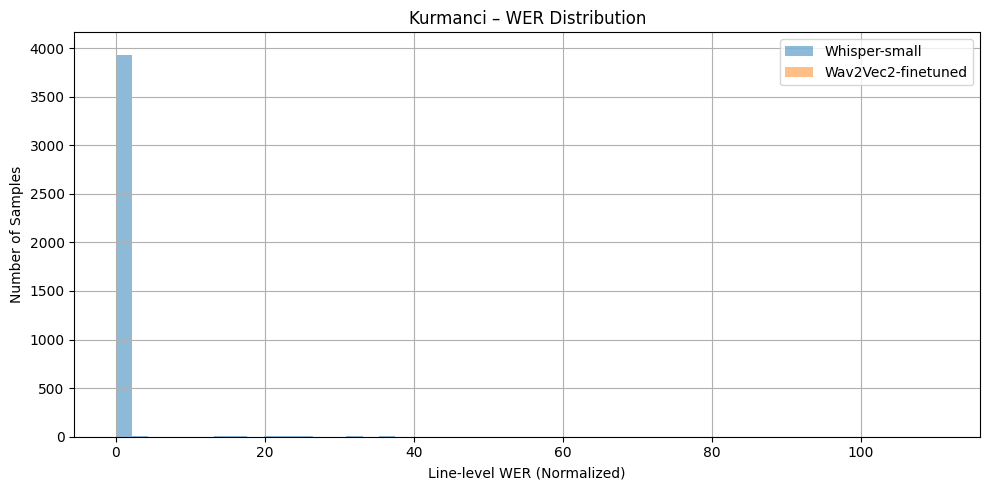

In [19]:
# ✅ Cell 8: Plot WER Histograms
# ✅ Only keep rows where both WERs are valid
df_plot = df_clean.dropna(subset=["whisper_line_wer", "w2v2_line_wer"])

plt.figure(figsize=(10, 5))
plt.hist(df_plot["whisper_line_wer"], bins=50, alpha=0.5, label="Whisper-small")
plt.hist(df_plot["w2v2_line_wer"], bins=50, alpha=0.5, label="Wav2Vec2-finetuned")
plt.xlabel("Line-level WER (Normalized)")
plt.ylabel("Number of Samples")
plt.title("Kurmanci – WER Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


